# Monochromator Optimization

In this notebook you will:

* Use a custom plan that is tuned to a specific, common task at an XAFS beamline.
* This plan will take some readings, do some prompt analysis on those readings, and then immediately take an action based on the result.

## Science Background

Here is a schematic of a double crystal monochromator (DCM), like the one at BMM and many other beamlines.  The broadband radiation from the 3-pole wiggler source is incident upon the first crystal of the DCM.  At BMM, we most often use a Si(111) DCM and have the option to use Si(311) crystals.  The schematic below applies equally well to either crystal type and to any other crystal monochrmoator, as well. 

The first crystal monochromates the X-ray beam by Bragg diffraction. The crystal is on a high-preceision rotation stage and the angle between the incident beam and the lattice planes of the crystal is chosen so that a specific wavelength meets the Bragg condition, $\lambda = 2d\sin(\Theta)$, where $d$ is the spacing between the lattice planes of the crystal and $\Theta$ is the angle between the incident beam and the lattice planes of the first crystal.  By changing the angle, we change the wavelength of the beam diffracting from the first crystal.  Because there is a simple relationship between wavelength and energy, we select X-ray energy by changing the angle of the first crystal.

![DCM](./static/doubleb.gif)  [(image source)](http://pd.chem.ucl.ac.uk/pdnn/inst2/condit.htm)

The second crystal of the DCM is used to direct the beam downstream, towards the experimental hutch.  The second crystal needs to be at the same angle as the first crystal in order to meet the Bragg condition for the wavelength selected by the first crystal.  In order to pass the X-rays with high efficiency through the DCM, the first and second crystals must be parallel, within microradians. 

Whenever we make a large change in energy -- for example, when moving between elements with absorption edge energies that are very far apart -- it is prudent to verify that this difference in angle is small.  This is done by making a scan of the pitch of the second crustal, monitoring the intensity of the X-ray beam in the experimental hutch. When the second crystal is perfectly parallel to the first crystal, the intensity of the X-rays passing the the onochromator is maximized.  Thus this pitch scan of the second crystal will be a peaked function.  We want to place the second crystal pitch at the maximum of this peak.
 
## Running a beamline

BlueSky provides all the tools we need to perform this optimization.  Here's the game plan:

1. Perform a scan of the pitch motor over a range that will include the optimal pitch position
2. Record an intensity signal from a detector downstream of the DCM
3. When the scan is finished, analyze the intensity measurements and determine the position of peak intensity
4. Move the second crystal pitch motor to its optimized position

BlueSky has you covered.  It comes with scan plans that perfom steps 1 and 2.  Step 3 is readily implemented using tools from Numerical and Scientific Python.  Step 4 is handled by one of BlueSky's standard motor motion commands.  None of this is difficult ... *except* that you need to know some things:

* The name of the motor to be scanned
* The name of the detector to be monitored
* The syntax of the mathematical tools used to analyze the measured data
* The names of the standard plans for scanning and moving motors

For the beamline staff, those things should be common knowledge.  For a general user or a new post-doc, those things are esoteric mysteries.

Training a user to remember the names of everything and the sequence of commands to run in order to perform this scan is certainly possible, but certainly  challanging. At an XAFS beamline, this optimization might be needed dozens of times each day -- and it **must** be done correctly *every single time*. Even a modestly complicated procedure like this optimization becomes a serious friction point in the use of the beamline.

A solution to this friction is make a bespoke measurement plan, tailored to the beamline and constructed from the basic plans provided by BlueSky.  That is, we make a plan that performs all the steps of this optimization chore.  Thus, instead of training the general user or new post-doc the steps of the optimization, you simply have to train them to run this one plan when it is needed.

In the XAFS community, we usually call this monochromator optimization a "rocking curve scan".  (We are "rocking" the second crystal through its optimal position and measuring the resulting peak-shaped curve.)  The `rocking_curve()` plan explained below is used reliably everyday by users and staff at BMM.

--------

## Tutorial

We start by setting up our BlueSky environment:

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from bluesky import RunEngine
from bluesky_tutorial_utils import setup_data_saving


RE = RunEngine()
catalog = setup_data_saving(RE)

We will import a Bluesky *plan* from a script in the current directory, [plans.py](./plans.py). The plan operates on simulated hardware defined in another script, [simulated_hardware.py](./simulated_hardware.py). For the purposes of this tutorial we do not need to interact with the hardware directly; it's all done through the plan. You are encouraged to examine [plans.py](./plans.py) to understand how the rocking curve scan is implemented.

In [2]:
from plans import rocking_curve

help(rocking_curve)

Help on function rocking_curve in module plans:

rocking_curve(start=-0.1, stop=0.1, nsteps=101, choice='peak')
    Perform a relative scan of the DCM 2nd crystal pitch around the current
    position to find the peak of the crystal rocking curve.  Begin by opening
    the hutch slits to 3 mm. At the end, move to the position of maximum
    intensity on I0, then return to the hutch slits to their original height.
    Input:
      start:    (float)  starting position relative to current  [-0.1]
      end:      (float)  ending position relative to current    [0.1]
      nsteps:   (int)    number of steps                        [101]
      choice:   (string) 'peak', fit' or 'com' (center of mass) ['peak']
    If choice is fit, the fit is performed using the
    SkewedGaussianModel from lmfit, which works pretty well for this
    measurement at BMM.  The line shape is a bit skewed due to the
    convolution with the slightly misaligned entrance slits.



In [3]:
plt.figure()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [4]:
RE(rocking_curve())

rocking curve scan: pitch, I0, -0.100, 0.100, 101 -- starting at 4.000
	uid = 03ea52c0-5722-46b7-9ba6-9dec110cc03e, scan_id = 1
Found and moved to peak at 4.04 via method peak


('03ea52c0-5722-46b7-9ba6-9dec110cc03e',)

Note that the `rocking_curve()` plan performs the scan of the DCM second crystal while monitoring the intensity signal, then analyzes the result to find the position of maximum intensity, and finally moves the second crystal pitch to that position.  At this point, the DCM is optimized and the beamline is ready to begin measuring XAFS in the range of the current energy of the DCM.

Now let's look at a plot of the rocking curve data using matplotlib's `gcf` (i.e. [get current figure](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.gcf.html)) method. At the beamline, this is typically displayed as a live plot during the rocking curve scan.

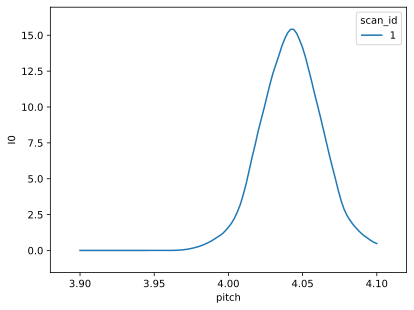

In [5]:
plt.gcf()  # Display a snapshot of the current state of the figure.

By default, the `rocking_curve()` plan simply looks for the position of highest intesity, then moves to that position.  In practice, this works quite well at BMM.

There are other ways to examine and interpret a peak-like function.  In fact, the `rocking_curve()` plan offers three algorithms for determining the peak position:

1. `peak`: find the position of maximum intensity
2. `com`: find the position of the [center of mass](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.center_of_mass.html) of the masured peak
3. `fit`: fit an analytic function to the measured data and find the centroid of that function.  In practice at BMM, we have found that a [skewed Gaussian function](https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel) works well.

Let's see how these work.

-------

First, we need to get the data from the measurement in a form that is convenient to work with. One of the things we set up back in the first step of this tutorial was a "catalog", i.e. a way of accessing the live data from a measurement. In the step that follows, the `run` vairable will contain the data from the `rocking_curve()` performed above.

In [6]:
run = catalog[-1]
run

BlueskyRun
  uid='03ea52c0-5722-46b7-9ba6-9dec110cc03e'
  exit_status='success'
  2020-05-14 15:42:47.982 -- 2020-05-14 15:42:54.093
  Streams:
    * primary


Access the saved data.

In [7]:
data = run.primary.read()
data

<xarray.Dataset>
Dimensions:                   (time: 101)
Coordinates:
  * time                      (time) float64 1.589e+09 1.589e+09 ... 1.589e+09
Data variables:
    pitch                     (time) float64 3.9 3.902 3.904 ... 4.096 4.098 4.1
    pitch_setpoint            (time) float64 3.9 3.902 3.904 ... 4.096 4.098 4.1
    I0                        (time) float64 0.001037 0.001037 ... 0.5701 0.4802
    pitch:pitch_velocity      (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    pitch:pitch_acceleration  (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    I0:I0                     (time) float64 0.001037 0.001037 ... 0.001037
    seq_num                   (time) int64 1 2 3 4 5 6 7 ... 96 97 98 99 100 101
    uid                       (time) <U36 '098947cb-d0d4-4a0a-ba34-559a3ff46f9e' ... '93de941a-87ca-4f1d-813b-f2f67032a52b'

Plot I0 vs pitch.

In [8]:
plt.figure()  # New figure

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

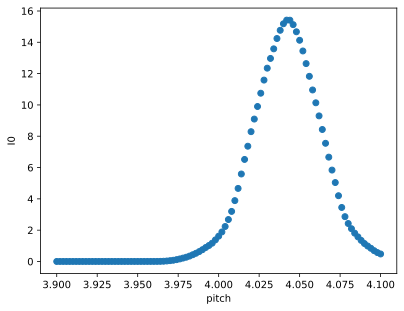

In [9]:
data.plot.scatter("pitch", "I0")
plt.gcf()  # Display a snapshot of the current state of the figure.

We could have gone straight to the plot in one line by chaining all of this together.

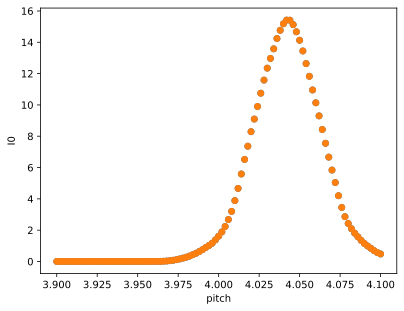

In [10]:
catalog[-1].primary.read().plot.scatter("pitch", "I0")
plt.gcf()  # Display a snapshot of the current state of the figure.

-----

The variable `data` contains the result of our just completed rocking curve measurement. The type of this data is [xarray Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).  In the following, we will work instead with a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).  Here, we convert the xarray Dataset to a pandas DataFrame:

In [11]:
df = data.to_dataframe()
df

,pitch,pitch_setpoint,I0,pitch:pitch_velocity,pitch:pitch_acceleration,I0:I0,seq_num,uid
time,,,,,,,,
1.589471e+09,3.900,3.900,0.001037,1,1,0.001037,1,098947cb-d0d4-4a0a-ba34-559a3ff46f9e
1.589471e+09,3.902,3.902,0.001037,1,1,0.001037,2,384da154-b246-429d-996e-bce1772ebb87
1.589471e+09,3.904,3.904,0.001037,1,1,0.001037,3,040c4327-c600-4b60-b028-47e635f15665
1.589471e+09,3.906,3.906,0.000835,1,1,0.001037,4,85bcfa58-7cc4-4800-9d93-fa00b89e0989
1.589471e+09,3.908,3.908,0.000925,1,1,0.001037,5,3bf14e93-cf59-44ab-a40b-939512c8e319
...,...,...,...,...,...,...,...,...
1.589471e+09,4.092,4.092,0.988044,1,1,0.001037,97,641936e8-f3fb-48ec-8255-ac7d182d8b06
1.589471e+09,4.094,4.094,0.843324,1,1,0.001037,98,9b51a58c-0d66-4a5d-a891-650469058640
1.589471e+09,4.096,4.096,0.690857,1,1,0.001037,99,07ea57c7-3580-4b99-8d25-dfad12d59cbd


Let's take a slice out of that DataFrame so we can focus on the most relevant parts of this data record, i.e. the values of pitch throughout the scan and the beam intensity at each value of pitch (taken from a detector named `I0`):

In [12]:
measurement = df.loc[:, ['I0', 'pitch']]
measurement

,I0,pitch
time,,
1.589471e+09,0.001037,3.900
1.589471e+09,0.001037,3.902
1.589471e+09,0.001037,3.904
1.589471e+09,0.000835,3.906
1.589471e+09,0.000925,3.908
...,...,...
1.589471e+09,0.988044,4.092
1.589471e+09,0.843324,4.094
1.589471e+09,0.690857,4.096


### Moving to the peak of the rocking curve

First we find the time index of the data point which has the highest `I0` value, i.e. the peak of the plot above.

In [13]:
i0max = measurement['I0'].idxmax()
i0max

1589470972.379245

Now we find the value of pitch at which the `I0` intensity was maximum:

In [14]:
optimal_pitch = measurement.loc[i0max, 'pitch']
optimal_pitch

4.042

Finally, we want to move the pitch motor to its optimal value.  In the `rocking_curve()` plan actually used at BMM, we have a line like:
```
RE(mv(pitch, optimal_pitch))
```

### Moving to the center of mass of the rocking curve

SciPy's center of mass calculation is an N-dimensional generalization of the sort of gravitational center of mass calculation you might remember from your mechanics class in physics.  In this case, the `I0` values at each point of the measurement are used as the "mass" of each position in the array.  This way of optimizing the DCM second crystal position might be useful if the measured peak is highly assymetric.

The center of mass calculation will return a real number, not an integer.  That is, the center of mass will be between two of the actual measured points.  The line below with `int(round( ... ))` returns the index closest to the center of mass, which we then move to.  Alternately, you could interpolate to the position of the actual center of mass, but we have opted for the simpler solution here.

In [15]:
from scipy.ndimage.measurements import center_of_mass
import numpy
arr = numpy.array(measurement['I0'])
val = int(round(center_of_mass(arr)[0]))
val

71

In [16]:
optimal_pitch = measurement['pitch'].iloc[val]
optimal_pitch

4.042

Again, we want to move the pitch motor to its optimal value. So something like like:
```
RE(mv(pitch, optimal_pitch))
```

### Fitting a peak function to the rocking curve measurement

Sometimes, when interpreting a peak-like function, it is preferable to bring some more prior knwoeldge to the interpretation.  If you know a line shape that provides a good physical description of the measurement, then fitting that line shape might provide you with more information.

Here is how we use [lmfit](https://lmfit.github.io/lmfit-py/) to fit a simple skewed Gaussian model to our rocking curve measurement.

First we convert the I0 and pitch columns of the DataFrame to NumPy arrays, which we then feed to lmfit's skewed Gaussian model.  From these, we guess initial parameters.  We run the fit, then print the results and prepare a plot showing those results.  Finally we set the `optimal_pitch` parameter for use in the same manner as for the peak and center-of-mass interpretations.

In [17]:
from lmfit.models import SkewedGaussianModel
signal = numpy.array(measurement['I0'])
position = numpy.array(measurement['pitch'])
mod = SkewedGaussianModel()
pars = mod.guess(signal, x=position)
out = mod.fit(signal, pars, x=position)
print(out.fit_report(min_correl=0))
out.plot()
optimal_pitch = out.params["center"].value
optimal_pitch

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 101
    # variables        = 4
    chi-square         = 2.05451858
    reduced chi-square = 0.02118060
    Akaike info crit   = -385.402975
    Bayesian info crit = -374.942493
[[Variables]]
    amplitude:  0.75779889 +/- 0.00212435 (0.28%) (init = 1.017352)
    center:     4.03788513 +/- 0.00480334 (0.12%) (init = 4.042)
    sigma:      0.02048253 +/- 0.00108203 (5.28%) (init = 0.022)
    gamma:      0.28674062 +/- 0.31991513 (111.57%) (init = 0)
[[Correlations]] (unreported correlations are < 0.000)
    C(center, gamma)     = -1.000
    C(center, sigma)     = -0.998
    C(sigma, gamma)      =  0.998
    C(amplitude, sigma)  =  0.074
    C(amplitude, center) = -0.041
    C(amplitude, gamma)  =  0.039


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

4.037885131758955

Finally, we move the pitch motor to its optimal value. So something like like:
```
RE(mv(pitch, optimal_pitch))
```  
We can examine the result of the fit by showing the plot:

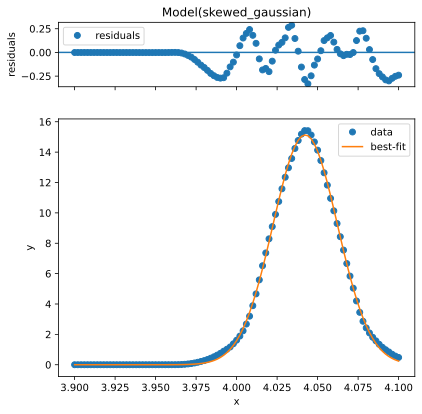

In [18]:
plt.gcf()

The peak and center-of-mass algorithms only return the optimal position.  An advantage of a fitted analysis of the measurement is that we terms for the amplitide, width, and (in this case) peak assymetry.  While we do not need those terms for the purpose of optimizing the rocking curve, in other situations that kind of information might be actionable in a plan like this one.

-----

## In conclusion

At BMM, we usually run this rocking curve scan using the peak interpretation.  That is the default, so the plan is typically run like so:
```
RE(rocking_curve())
```
You can specify the kind of intepretation by using the `choice` argument.  This is equivalent to the default:
```
RE(rocking_curve(choice='peak'))
```
Here is the center of mass calculation:
```
RE(rocking_curve(choice='com'))
```
and here is the fitted interpretation:
```
RE(rocking_curve(choice='fit'))
```

You could go way back to the third step of this tutorial and give each a try.  You will find that the three give slightly different answers for the optimized position of the DCM second crystal.

### Hierarchies of plans in BlueSky

In truth, the rocking curve plan is rarely called directly either by staff or by users at BMM.  It is, nonetheless, used many times each day.  At BMM, we have a plan called `change_edge()` that is used to automate the reconfiguration of the beamline for measurements in different energy ranges.  This plan is how the staff and users typically perform the rocking curve chore.

The `change_edge()` plan requires an argument specifying the element of the next experiment.  So, if we want to begin measuring the iron K edge of iron-bearing samples, we do:
```
RE(change_edge('Fe'))
```
This plan 

1. verifies that the photon delivery system is in the correct configuration for the specified energy range
2. performs a rocking curve scan just like the one in this tutorial
3. optimizes the position of the beam-definition slits
4. makes sure detectors are properly configured to make measurements at the chosen absorption edge

leaving the beamline completely optimized for measurement at the selected absorption edge.

The reason such a magical plan is possible is because, in BlueSky, plans are composed of plans.  

Just as the rocking curve plan is built from basic plans (specifically the `rel_scan()` and `mv()` plans), complex user-defined plans are composed of simpler user-defined plans.  At BMM, we have plans for each item `change_edge()` chore list.  Thus, the `change_edge()` plan is composed of these smaller plans such as `rocking_curve()`.  

By building complicated plans out of well-tested, single-purpose plans, we are able to perform automation at the beamline in ways that make the beamline easy to operate for staff and users alike.  In fact, at BMM, we allow *and* encourage our users to run the `change_edge()` command all by themselves!
